<a href="https://colab.research.google.com/github/andrei-micuda/TheWardrobeVue/blob/master/ClothesClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copy the DeepFashion dataset from Google Drive to the local Colab file system.

In [1]:
!unzip -qq /content/drive/MyDrive/DeepFashion/img.zip -d /content/raw_dataset

In [2]:
!cp /content/drive/MyDrive/DeepFashion/Anno/list_category_cloth.txt /content/raw_dataset/list_category_cloth.txt
!cp /content/drive/MyDrive/DeepFashion/Anno/list_category_img.txt /content/raw_dataset/list_category_img.txt
!cp /content/drive/MyDrive/DeepFashion/Anno/list_eval_partition.txt /content/raw_dataset/list_eval_partition.txt

In [11]:
!rm -r dataset

Create the necessary file structure in order to use `tf.keras.utils.image_dataset_from_directory`.

In [3]:
import os, shutil, pathlib

new_base_dir = pathlib.Path("/content/dataset")
original_dir = pathlib.Path("/content/raw_dataset")

In [4]:
def read_categories():
    dir = original_dir / "list_category_cloth.txt";
    with open(dir) as fin:
        fin.readline();
        fin.readline();
        return [line.strip().split()[0] for line in fin.readlines()];
    
def create_folder_structure(subset_name, categories):
    for cat in categories:
        dir = new_base_dir / subset_name / cat
        os.makedirs(dir)
        
def populate_folders():
    with open(original_dir / "list_category_img.txt") as img_cats, open(original_dir / f"list_eval_partition.txt") as img_subsets:
        img_cats.readline();
        img_subsets.readline();
        img_cats.readline();
        img_subsets.readline();
        
        for i, (img_cat, img_subset) in enumerate(zip(img_cats.readlines(), img_subsets.readlines())):
            img_path, img_cat = img_cat.strip().split()
            _, img_subset = img_subset.strip().split()
            cat_name = categories[int(img_cat) - 1]
            
            save_path = new_base_dir / img_subset / cat_name
            original_path = original_dir / img_path
            shutil.copyfile(src=original_path, dst=save_path / f"{img_cat}_image_{i}.jpg")
            if(i % 10000 == 0):
                print(f"Finished copying {i} images")
    
categories = read_categories();
create_folder_structure("train", categories);
create_folder_structure("val", categories);
create_folder_structure("test", categories);

populate_folders();

Finished copying 0 images
Finished copying 10000 images
Finished copying 20000 images
Finished copying 30000 images
Finished copying 40000 images
Finished copying 50000 images
Finished copying 60000 images
Finished copying 70000 images
Finished copying 80000 images
Finished copying 90000 images
Finished copying 100000 images
Finished copying 110000 images
Finished copying 120000 images
Finished copying 130000 images
Finished copying 140000 images
Finished copying 150000 images
Finished copying 160000 images
Finished copying 170000 images
Finished copying 180000 images
Finished copying 190000 images
Finished copying 200000 images
Finished copying 210000 images
Finished copying 220000 images
Finished copying 230000 images
Finished copying 240000 images
Finished copying 250000 images
Finished copying 260000 images
Finished copying 270000 images
Finished copying 280000 images


Load the images into datasets.

In [5]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    batch_size=32,
    label_mode='categorical')

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    batch_size=32,
    label_mode='categorical')

val_dataset = image_dataset_from_directory(
    new_base_dir / "val",
    batch_size=32,
    label_mode='categorical')

Found 209222 files belonging to 50 classes.
Found 40000 files belonging to 50 classes.
Found 40000 files belonging to 50 classes.


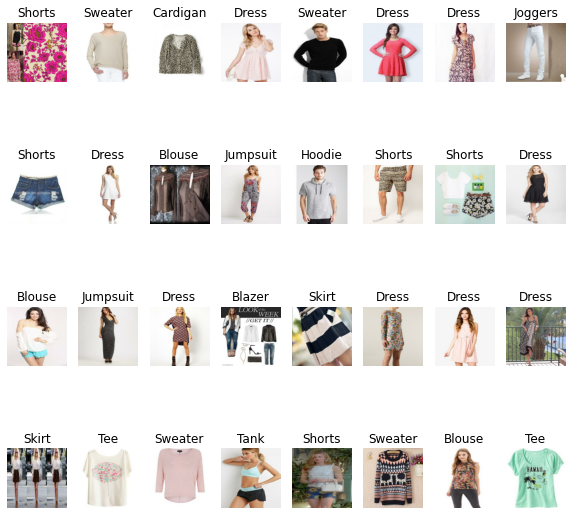

In [9]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))
class_names = test_dataset.class_names
for images, labels in test_dataset.take(1):
    for i in range(32):
        ax = plt.subplot(4, 8, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

We are going to leverage the VGG16 base convolution network for feature extraction.

In [9]:
from tensorflow import keras
from tensorflow.keras import layers

conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(256, 256, 3))
conv_base.trainable = False

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(4096, activation="relu")(x)
x = layers.Dense(4096, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(50, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset)

# test_model = keras.models.load_model(
#     "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

Epoch 1/10
6539/6539 [==============================] - 1972s 301ms/step - loss: 3.0831 - accuracy: 0.3563 - val_loss: 2.8469 - val_accuracy: 0.3824
Epoch 2/10
1757/6539 [=======>......................] - ETA: 20:50 - loss: 2.6476 - accuracy: 0.3107

KeyboardInterrupt: ignored

In [11]:
from tensorflow import keras
from tensorflow.keras import layers

conv_base = keras.applications.resnet50.ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(256, 256, 3))
conv_base.trainable = False

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)
x = keras.applications.resnet50.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
outputs = layers.Dense(50, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset)

# test_model = keras.models.load_model(
#     "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

Epoch 1/10
6539/6539 [==============================] - 1135s 173ms/step - loss: 33.2069 - accuracy: 0.4462 - val_loss: 36.2511 - val_accuracy: 0.4985
Epoch 2/10
6539/6539 [==============================] - 1131s 173ms/step - loss: 35.4011 - accuracy: 0.4888 - val_loss: 38.6084 - val_accuracy: 0.4787
Epoch 3/10
6539/6539 [==============================] - 1132s 173ms/step - loss: 36.0365 - accuracy: 0.5072 - val_loss: 39.0570 - val_accuracy: 0.5231
Epoch 4/10
6539/6539 [==============================] - 1131s 173ms/step - loss: 36.5226 - accuracy: 0.5185 - val_loss: 40.5477 - val_accuracy: 0.5522
Epoch 5/10
6539/6539 [==============================] - 1131s 173ms/step - loss: 36.9107 - accuracy: 0.5277 - val_loss: 43.1389 - val_accuracy: 0.5059
Epoch 6/10
6539/6539 [==============================] - 1131s 173ms/step - loss: 37.3744 - accuracy: 0.5334 - val_loss: 46.1604 - val_accuracy: 0.5014
Epoch 7/10
6539/6539 [==============================] - 1130s 173ms/step - loss: 37.6227 - acc

KeyboardInterrupt: ignored